# **Proyek Kedua : Membuat Model Machine Learning dengan Data Time Series**

* Nama : Firman Nurcahyo
* Email : firman.cahyo.369@gmail.com
* ID DiCoding : Firman Nurcahyo

# **Mengimport Modul Yang Diperlukan**

In [30]:
import pandas as pd
import numpy as np
from keras.layers import Dense, LSTM
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf

In [31]:
# Read the CSV file 'Tomato.csv' into a DataFrame named 'df'
df = pd.read_csv('Tomato.csv')
print(df)

            Date Unit  Minimum  Maximum  Average  Market
0     2013-06-16   Kg       26       32     29.0  Tomato
1     2013-06-17   Kg       20       25     22.5  Tomato
2     2013-06-18   Kg       22       26     24.0  Tomato
3     2013-06-19   Kg       24       28     26.0  Tomato
4     2013-06-20   Kg       22       26     24.0  Tomato
...          ...  ...      ...      ...      ...     ...
2736  2021-05-09   Kg       10       15     12.5  Tomato
2737  2021-05-10   Kg       10       15     12.5  Tomato
2738  2021-05-11   Kg       10       15     12.5  Tomato
2739  2021-05-12   Kg       30       35     32.5  Tomato
2740  2021-05-13   Kg       35       40     37.5  Tomato

[2741 rows x 6 columns]


In [32]:
# Check for null values in the DataFrame 'df'
null_counts = df.isnull().sum()
print("Null counts in df:")
print(null_counts)

# Select the 'Date' and 'Average' columns into a new DataFrame 'dt'
dt = df[['Date', 'Average']]

# Display the new DataFrame 'dt'
print("\nSubset of df with 'Date' and 'Average' columns")
print(dt)

Null counts in df:
Date       0
Unit       0
Minimum    0
Maximum    0
Average    0
Market     0
dtype: int64

Subset of df with 'Date' and 'Average' columns
            Date  Average
0     2013-06-16     29.0
1     2013-06-17     22.5
2     2013-06-18     24.0
3     2013-06-19     26.0
4     2013-06-20     24.0
...          ...      ...
2736  2021-05-09     12.5
2737  2021-05-10     12.5
2738  2021-05-11     12.5
2739  2021-05-12     32.5
2740  2021-05-13     37.5

[2741 rows x 2 columns]


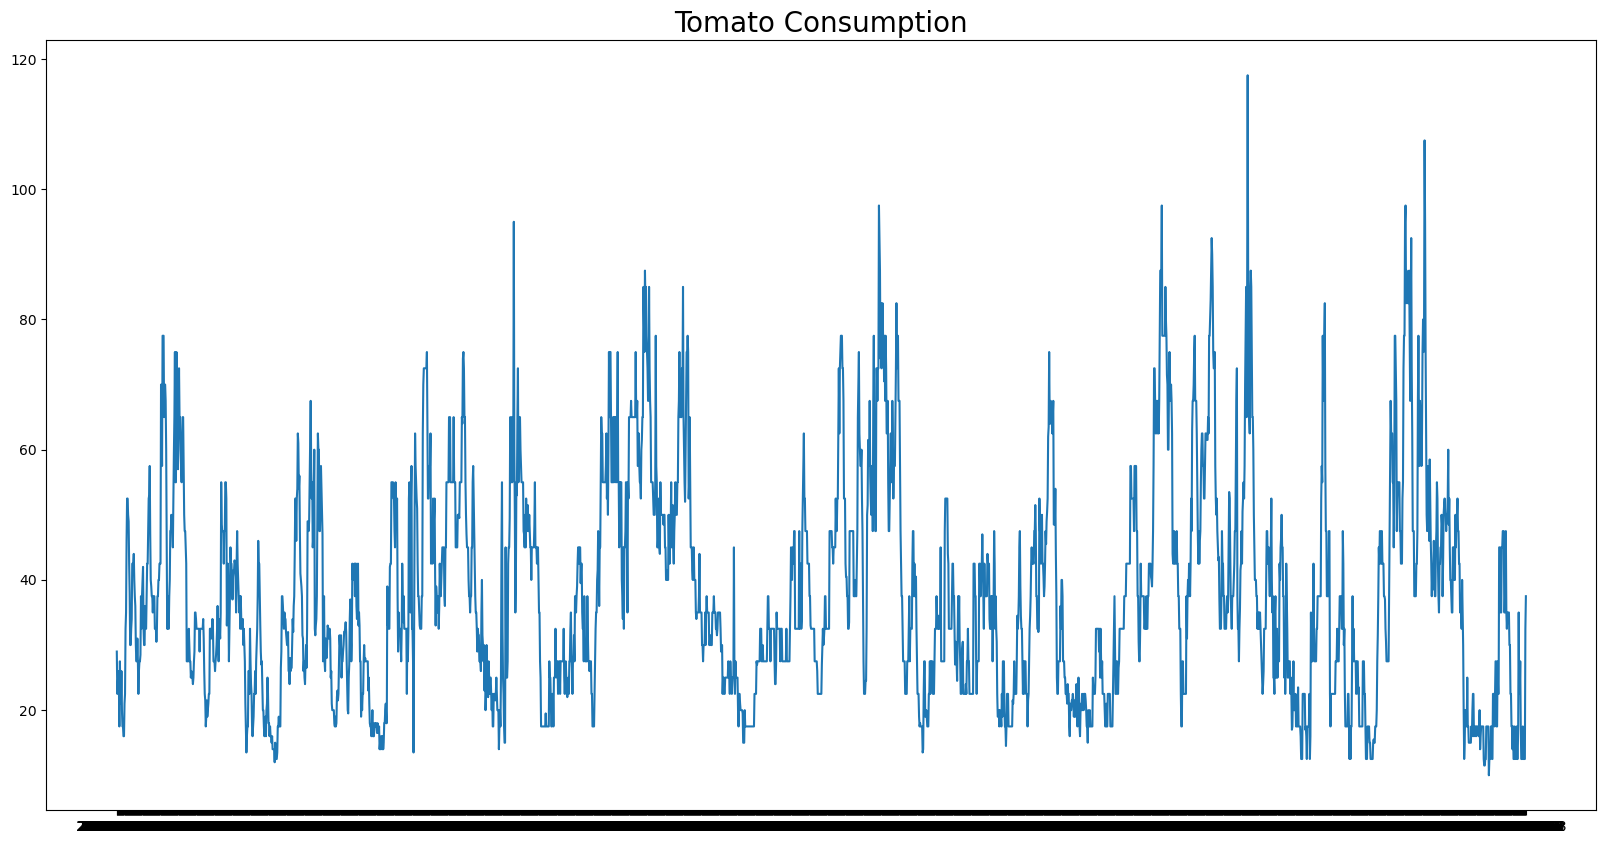

In [33]:
# Extract 'Date' and 'Average' columns from the DataFrame 'dt'
dates = dt['Date'].values
tomato = dt['Average'].values

# Convert the lists to numpy arrays
dates = np.array(dates)
tomato = np.array(tomato)

plt.figure(figsize=(20, 10))
plt.plot(dates, tomato)
plt.title('Tomato Consumption', fontsize=20)
plt.show()

In [34]:
# Split the data into training and validation sets
x_train, x_valid, y_train, y_valid = train_test_split(
    tomato, dates, test_size=0.2, shuffle=False
)

In [36]:
# Display the number of data points in the training and validation sets
print('Number of training data points :', len(x_train))
print('Number of validation data points :', len(x_valid))
print('Total number of data points :', len(x_train) + len(x_valid))

Number of training data points : 2192
Number of validation data points : 549
Total number of data points : 2741


In [37]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    
    # Batch the dataset and prefetch one batch
    return ds.batch(batch_size).prefetch(1)

In [38]:
# Create windowed datasets for training and validation
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=1000)
val_set = windowed_dataset(x_valid, window_size=60, batch_size=100, shuffle_buffer=1000)

# Define the sequential model
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.LSTM(60),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),

    tf.keras.layers.Dense(1),
])

In [39]:
# Define the SGD optimizer with a learning rate and momentum
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)

# Compile the model with Huber loss, SGD optimizer, and MAE metric
model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=optimizer,
    metrics=["mae"]
)

# Train the model on the training set, with validation on the validation set
history = model.fit(
    train_set,
    epochs=100,
    validation_data=val_set
)

Epoch 1/100
22/22 [==============================] - 6s 117ms/step - loss: 38.3841 - mae: 38.8841 - val_loss: 33.7058 - val_mae: 34.2058
Epoch 2/100
22/22 [==============================] - 2s 77ms/step - loss: 38.2318 - mae: 38.7318 - val_loss: 33.6048 - val_mae: 34.1048
Epoch 3/100
22/22 [==============================] - 2s 72ms/step - loss: 38.1363 - mae: 38.6363 - val_loss: 33.5113 - val_mae: 34.0113
Epoch 4/100
22/22 [==============================] - 2s 77ms/step - loss: 38.0359 - mae: 38.5359 - val_loss: 33.4031 - val_mae: 33.9031
Epoch 5/100
22/22 [==============================] - 2s 67ms/step - loss: 37.8950 - mae: 38.3950 - val_loss: 33.2231 - val_mae: 33.7231
Epoch 6/100
22/22 [==============================] - 1s 62ms/step - loss: 37.6158 - mae: 38.1158 - val_loss: 32.8784 - val_mae: 33.3784
Epoch 7/100
22/22 [==============================] - 2s 70ms/step - loss: 37.2453 - mae: 37.7453 - val_loss: 32.4870 - val_mae: 32.9870
Epoch 8/100
22/22 [============================

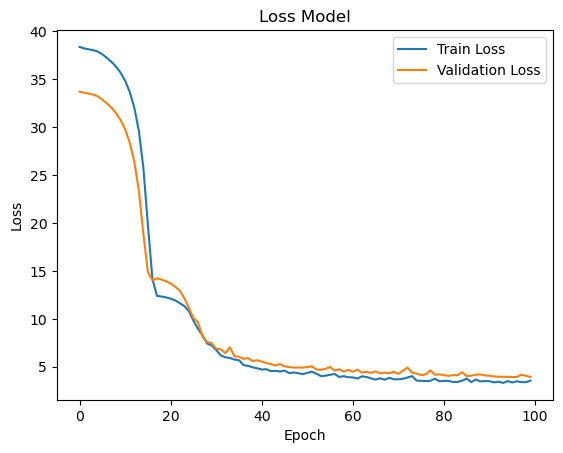

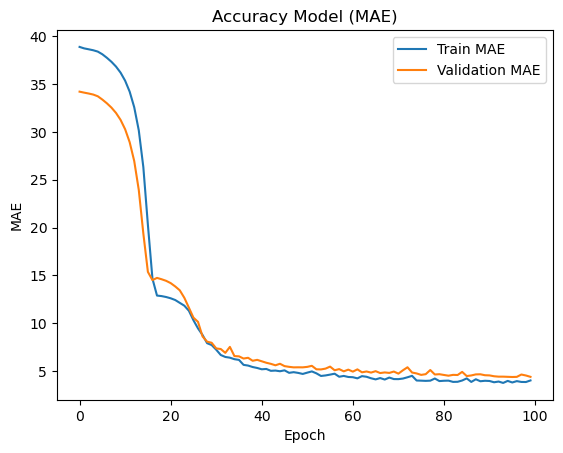

In [41]:
# Plot Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Plot Accuracy (MAE)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Accuracy Model (MAE)')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [42]:
# Define a custom callback class
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        # Check if the MAE is below 10
        if logs.get('mae') < 10:
            print("\nMAE has reached below 10!")
            self.model.stop_training = True

# Instantiate an object of the custom callback class
callbacks = myCallback()

In [43]:
history = model.fit(
    train_set,
    epochs=100,
    validation_data=val_set,
    callbacks=[callbacks]  # Include the custom callback
)

Epoch 1/100
     21/Unknown - 1s 62ms/step - loss: 3.3583 - mae: 3.8098
MAE has reached below 10!
22/22 [==============================] - 2s 72ms/step - loss: 3.3505 - mae: 3.8025 - val_loss: 4.0346 - val_mae: 4.5074
